In [11]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import bayesoptlib as BO


In [12]:
def f(x1,x2,x3,x4,Psp= 50, pfo = 0.5):
    # x1,x3 = fuel oil to G1,G2 tons/h
    # x2,x4 = Medium Btu gas to G1,G2 fuel units/h
    P1 = 5*x1 + 0.2*x1**2 + 4*x2 + 0.06*x2**2 # Power output MW
    P2 = 4*x3 + 0.05*x3**3 + 3.5*x4 + 0.02*x4**2 
    J = np.abs(P1+P2-Psp) + pfo*(x1 + x3)
    return J,P1,P2

inputDim = 3

x1 = 5.8
x2 = 0.1
x3 = 1
x4 = 5-x2

J,P1,P2 = f(x1,x2,x3,x4,50)
print(J,P1,P2)

from scipy.optimize import minimize
def f1(x, Psp=50, pfo=0.5):
    # Unpack variables
    x1, x2, x3, x4 = x
    
    # Calculate power outputs P1 and P2
    P1 = 5 * x1 + 0.2 * x1**2 + 4 * x2 + 0.06 * x2**2  # Power output MW
    P2 = 4 * x3 + 0.05 * x3**3 + 3.5 * x4 + 0.02 * x4**2 
    
    # Calculate the cost function J
    J = np.abs(P1 + P2 - Psp) + pfo * (x1 + x3) 
    
    return J, P1, P2
def objective(x, Psp=50, pfo=0.5):
    # We only return J since minimize only handles the scalar value
    J, _, _ = f1(x, Psp, pfo) 
    return J
def optimize_cost(Psp=50, pfo=0.5,P1_bounds=(18, 30), P2_bounds=(14, 25)):
    # Initial guesses for x1, x2, x3, x4
    initial_guess = [1, 1, 1, 1]
    
    # Bounds for x1, x2, x3, x4 - these should be adjusted based on practical constraints
    bounds = [(0, None), (0, None), (0, None), (0, None)]  # All variables should be non-negative
    
     # Constraint for x2 + x4 = 5
    constraints = [
        {'type': 'eq', 'fun': lambda x: x[1] + x[3] - 5},  # x2 + x4 = 5
        {'type': 'ineq', 'fun': lambda x: f1(x, Psp, pfo)[1] - P1_bounds[0]},  # P1 >= P1_min
        {'type': 'ineq', 'fun': lambda x: P1_bounds[1] - f1(x, Psp, pfo)[1]},  # P1 <= P1_max
        {'type': 'ineq', 'fun': lambda x: f1(x, Psp, pfo)[2] - P2_bounds[0]},  # P2 >= P2_min
        {'type': 'ineq', 'fun': lambda x: P2_bounds[1] - f1(x, Psp, pfo)[2]}   # P2 <= P2_max
    ]

    # Optimize the objective function
    result = minimize(objective, initial_guess, args=(Psp, pfo), bounds=bounds, constraints=constraints, method='SLSQP')
    
    
    # Extract the optimal values
    x_opt = result.x
    J_opt, P1_opt, P2_opt = f1(x_opt, Psp, pfo)
    
    return {
        'x1': x_opt[0],
        'x2': x_opt[1],
        'x3': x_opt[2],
        'x4': x_opt[3],
        'J_opt': J_opt,
        'P1_opt': P1_opt,
        'P2_opt': P2_opt
    }

# Example usage
optimal_solution = optimize_cost(Psp=50, pfo=0.5)
print(optimal_solution)

11.208800000000005 36.1286 21.680200000000003
{'x1': 3.5978200000848757, 'x2': 2.2776111421395755, 'x3': 2.4066895074515564, 'x4': 2.7223888578604245, 'J_opt': 3.0022547698803908, 'P1_opt': 29.99965707047273, 'P2_opt': 20.000342913415096}


In [19]:

x1 = 1
x2 = 1
x3 = 1
x4 = 5-x2


y1sp = 20
y2sp = 20
Psp = 50
for i in range(30):
    x1 = x1 + 0.22*(y1sp-P1)
    x3 = x3 + 0.25*(y2sp-P2)
    J,P1,P2 = f(x1,x2,x3,5-x2,Psp)

print(J,P1,P2,x1,x3)
Z_sample = np.concatenate((np.array(y1sp).reshape(-1,1),np.array(y2sp).reshape(-1,1),np.array(x2).reshape(-1,1)),axis=1)
ZD_sample = np.concatenate((Z_sample,np.array(Psp).reshape(-1,1)),axis=1)
J_sample = np.array(J).reshape(1,1) # Cost

var0 = 5
kernel_f = GPy.kern.RBF(inputDim+1,ARD = False, lengthscale=5,variance=var0) #+ GPy.kern.Bias(inputDim) 
bounds = np.array([[18,30],[14,25],[0,5]]) # bounds for Fb


U_range = np.linspace(bounds[:, 0].T, bounds[:, 1].T, 1000).reshape(1000,-1)


Jt = []
y1t = []
y2t = []
y1spt = []
y2spt = []
xt = []
Pt = []
Joptt = []
x1t = []
x2t= []

nIter = 40
for sim_k in range(nIter):
    Context = np.array(Psp).reshape(-1,1)
    J_Obj = BO.contextual_bayesian_optimization(ZD_sample,J_sample,
                                                Context,bounds,kernel_f, X_grid = U_range)

    
    # Update the posterior
    J_Obj.fit_gp()
    #if sim_k==10:
    #    J_Obj.optimize_fit()
    J_Obj.query_next('UCB')

    y1sp = J_Obj.X_next[0][0]
    y2sp = J_Obj.X_next[0][1]
    x2opt = J_Obj.X_next[0][2]


    # system query
    for j in range(30):
        x1 = x1 + 0.12*(y1sp-P1)
        x3 = x3 + 0.12*(y2sp-P2)
        x2 = 0.8*x2 + 0.2*x2opt
        J,P1,P2 = f(x1,x2,x3,5-x2,Psp)
        J+= 0.25*np.random.randn(1)
        P1+= 0.25*np.random.randn(1)
        P2+= 0.25*np.random.randn(1)
    
        Jt.append(J)
        y1t.append(P1)
        y2t.append(P2)
        xt.append(x2)
        y1spt.append(y1sp)
        y2spt.append(y2sp)
        Pt.append(P1+P2)
        Joptt.append(3.0022)
        x1t.append(20)
        x2t.append(5-x2)
    
    Z_sample = np.vstack((Z_sample, [[y1sp,y2sp,x2opt]]))
    
    ZD_sample = np.vstack((ZD_sample, J_Obj.X_next))
    J_sample = np.vstack((J_sample, J))
    
print(P1,P2,P1+P2,x1,x2,x3,5-x2,J)

[12.12366724] [20.] [20.] [2.86066405] [1.38667043]
[30.26463239] [19.97122582] [50.2358582] [5.03294076] 1.9679819680124147e-81 [0.45800641] 5.0 [2.90522685]


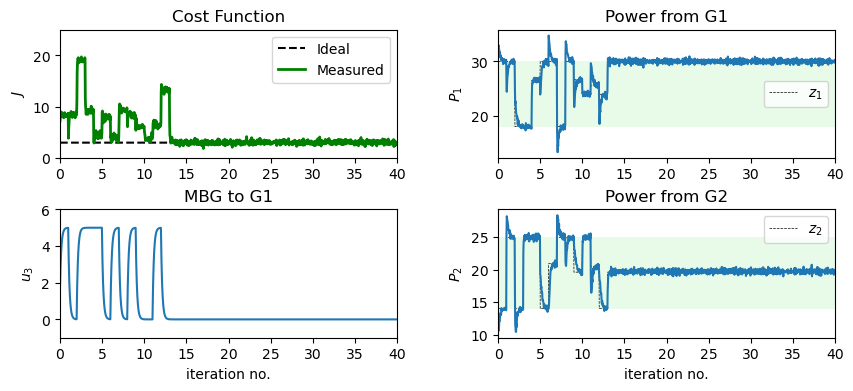

In [20]:
 
import matplotlib.gridspec as gridspec

# Create a 2x2 plot layout with each subplot 3x longer than tall
fig = plt.figure(figsize=(10, 4))  # Aspect ratio of 3x1 for each subplot
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, wspace=0.3, hspace=0.4)

iter = np.linspace(0,40,1200)
ax1 = fig.add_subplot(spec[0, 0])  # Top-left
ax2 = fig.add_subplot(spec[0, 1])  # Top-right
ax4 = fig.add_subplot(spec[1, 0])  # Bottom-left
ax3 = fig.add_subplot(spec[1, 1])  # Bottom-right

# First subplot
ax1.plot(iter,Joptt, 'k--', linewidth=1.5, label='Ideal')
ax1.plot(iter,Jt, 'g', linewidth=2, label='Measured')
ax1.set_ylabel('$J$')
ax1.set_xlim([0, 40])
ax1.set_ylim([0, 25])
ax1.legend()
ax1.set_title('Cost Function')

# Second subplot
ax2.plot(iter,y1spt, 'k--', linewidth=0.5, label='$z_1$')
ax2.plot(iter,y1t, linewidth=1.5)
ax2.set_ylabel('$P_1$')
#ax2.set_ylim([-8, 4])
ax2.set_xlim([0, 40])
#ax2.set_yticks([-8, -4, 0, 4])
ax2.axhspan(18, 30, facecolor='lightgreen', alpha=0.2)
ax2.legend()
ax2.set_title('Power from G1')

# Third subplot (Bottom-left)
ax3.plot(iter,y2spt, 'k--', linewidth=0.5, label='$z_2$')
ax3.plot(iter,y2t, linewidth=1.5)
ax3.set_ylabel('$P_2$')
#ax3.set_ylim([-8, 4])
ax3.set_xlim([0, 40])
#ax3.set_yticks([-8, -4, 0, 4])
ax3.axhspan(14, 25, facecolor='lightgreen', alpha=0.2)
ax3.set_xlabel('iteration no.')
ax3.legend()
ax3.set_title('Power from G2')

# Fourth subplot (Bottom-right)
ax4.plot(iter,xt, linewidth=1.5,label='$u_3$')
#ax4.plot(x2t, linewidth=1.5,label='$x_4$')
#ax4.plot(5-xt, 'k', linewidth=1.5)
ax4.set_ylabel('$u_3$')
ax4.set_ylim([-1, 6])
ax4.set_xlim([0, 40])
ax4.set_title('MBG to G1')
ax4.set_xlabel('iteration no.')
fig.savefig('Ex2_ts.pdf',bbox_inches='tight')
# Display the plot
plt.show()